Notebook to troubleshoot and play around with the time evolution of the Schwinger model using qualtran.



Additional imports of basic gates (e.g., CNOT, Hadamard) from qualtran for easier gate manipulation.


In [2]:
import cirq
import numpy as np
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma, show_bloqs
from typing import *
import sympy
from qualtran import SoquetT
from qualtran.symbolics import SymbolicFloat, SymbolicInt
from qualtran.bloqs.basic_gates import CNOT, Hadamard, XGate, SU2RotationGate, SGate
import attrs

Quick test of show_bloq() with a simple CNOT operation to confirm visualization functionality.


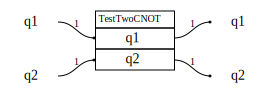

In [3]:
# show_bloq() test
class TestTwoCNOT(Bloq):
    @property
    def signature(self) -> Signature:
        return Signature.build(q1=1, q2=1)

    def build_composite_bloq(
        self, bb: 'BloqBuilder', q1: 'Soquet', q2: 'Soquet'
    ) -> Dict[str, 'Soquet']:
        q1, q2 = bb.add(CNOT(), ctrl=q1, target=q2)
        q1, q2 = bb.add(CNOT(), ctrl=q2, target=q1)
        return {'q1': q1, 'q2': q2}

show_bloq(TestTwoCNOT())

Define an Rz gate to be used in future circuits using qualtran's SU2RotationGate since no predefined qualtran Rz gate (or at least, I couldn't find one).


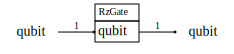

[[0.70710678-0.70710678j 0.        +0.j        ]
 [0.        +0.j         0.70710678+0.70710678j]]


/home/sam/GitHub2/Schwinger_model/schwinger_env/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [4]:
@attrs.frozen
class RzGate(Bloq):
    """
    A class representing the Rz gate.

    Attributes:
        gamma (float): The rotation paramete.
    """

    gamma: float  # The rotation parameter for the Z-axis

    @property
    def signature(self) -> Signature:
        """
        Define the signature for a single-qubit gate.
        """
        return Signature.build(qubit=1)

    def build_composite_bloq(self, bb: BloqBuilder, *, qubit: SoquetT) -> Dict[str, SoquetT]:
        """
        Decompose the generic SU2 rotation into an RzGate.
    
        """
        theta = 0
        phi = 0
        lambda_param = -self.gamma + np.pi  
        alpha = (self.gamma / 2) + np.pi    

        qubit = bb.add(SU2RotationGate(theta, phi, lambda_param, alpha), q=qubit)

        # Return the resulting qubit after the operation
        return {'qubit': qubit}


# Example usage of the RzGate with a pi/2 rotation
Z_rot_gate = RzGate(np.pi / 2)

show_bloq(Z_rot_gate)

# Perform tensor contraction and print the result
print(Z_rot_gate.tensor_contract())

Use qualtran's built-in QFT function (QFTTextBook) for the Incrementer and Decrementer Bloqs.


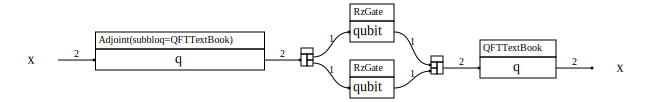

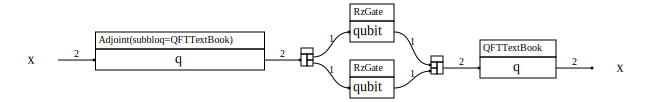

In [6]:
from qualtran.bloqs.qft import QFTTextBook

@attrs.frozen
class Incrementer(Bloq):
    """
    A class representing an Incrementer that increments an 'm'-qubit register by 1.

    Attributes:
        m (int): The number of qubits to increment.
    """
    
    m: int  # Number of qubits as input

    @property
    def signature(self) -> Signature:
        """
        Define the signature for the Incrementer Bloq. 
        The input and output are both 'm' qubits.
        """
        return Signature.build(x=self.m)

    def build_composite_bloq(self, bb: BloqBuilder, *, x: SoquetT) -> Dict[str, SoquetT]:
        """
        Decompose the incrementer operation using the Quantum Fourier Transform and Rz rotations.
        This function performs an increment-by-1 operation on the 'm'-qubit input.
        """
        
        # Apply the inverse QFT to the input qubits.
        x = bb.add(QFTTextBook(self.m).adjoint(), q=x)

        # Split the qubits for applying rotation gates.
        xs = bb.split(x)
        
        # Apply an Rz gate to each qubit with an appropriate rotation angle.
        for i in range(len(xs)):
            angle = 2 * np.pi * 2**i / (2**self.m)  # Rotation angle calculation
            xs[i] = bb.add(RzGate(angle), qubit=xs[i])

        # Rejoin the qubits after applying rotations.
        x = bb.join(xs)

        # Apply the QFT to the qubits to complete the increment operation.
        x = bb.add(QFTTextBook(self.m), q=x)

        # Return the resulting qubits after the increment operation.
        return {'x': x}

    def adjoint(self):
        """
        Return the adjoint (inverse) of the Incrementer Bloq.
        """
        return BloqBuilder.build_adjoint(self)
    
@attrs.frozen
class Decrementer(Bloq):
    """
    A class representing a Decrementer, which decrements an 'm'-qubit register by 1.
    Defined as the reverse of the Incrementer.
    """

    m: int  # Number of qubits as input

    @property
    def signature(self) -> Signature:
        """Define the signature for the Decrementer Bloq."""
        return Signature.build(x=self.m)

    def build_composite_bloq(self, bb: BloqBuilder, *, x: SoquetT) -> Dict[str, SoquetT]:
        """Define the Decrementer by reversing the Incrementer operations."""
        
        # Apply the inverse QFT (to reverse the final QFT in Incrementer)
        x = bb.add(QFTTextBook(self.m).adjoint(), q=x)

        # Split the qubits for applying reverse rotation gates.
        xs = bb.split(x)
        
        # Apply an Rz gate to each qubit with a negative rotation angle to reverse Incrementer
        for i in range(len(xs)):
            angle = -2 * np.pi * 2**i / (2**self.m)  # Reverse rotation angle calculation
            xs[i] = bb.add(RzGate(angle), qubit=xs[i])

        # Rejoin the qubits after applying reverse rotations.
        x = bb.join(xs)

        # Apply the QFT to complete the reverse operation.
        x = bb.add(QFTTextBook(self.m), q=x)

        return {'x': x}


# Testing the Incrementer and Decrementer
inc = Incrementer(2)
dec = Decrementer(2)
show_bloq(inc.decompose_bloq())
show_bloq(dec.decompose_bloq())


Incorporate above functions into the Hopping term circuit and test with show_bloq.

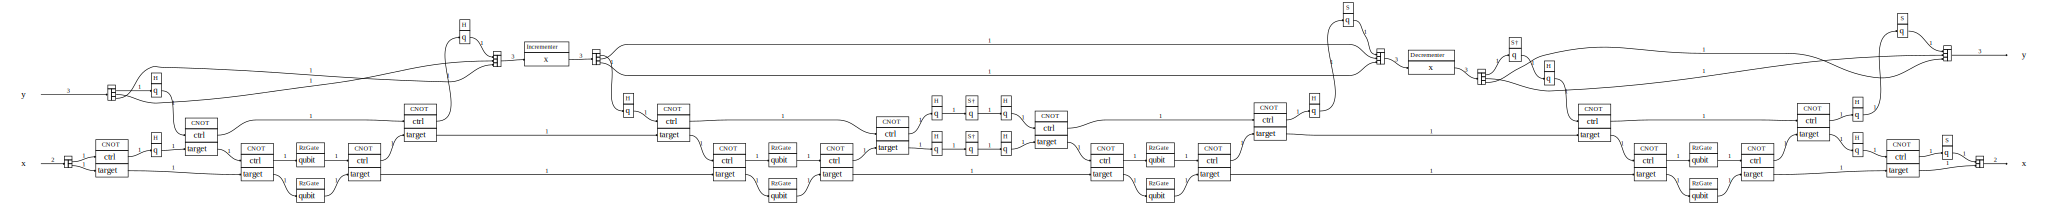

In [ ]:
@attrs.frozen
class HoppingTerm(Bloq):
    n: int = 2
    m: int = 2
    
    @property
    def signature(self) -> Signature:
        return Signature.build(x=self.n, y=self.m)

    angle: SymbolicFloat = 1 
    eps: SymbolicFloat = 1e-9 
    
    def build_composite_bloq(
            self, bb: BloqBuilder, *, x: SoquetT, y: SoquetT
    ) -> Dict[str, SoquetT]:
        xs = bb.split(x)
        ys = bb.split(y)

        # Using the order of gates from her code
        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])
        xs[0] = bb.add(Hadamard(), q=xs[0])
        ys[0] = bb.add(Hadamard(), q=ys[0])

        ys[0], xs[0] = bb.add(CNOT(), ctrl=ys[0], target=xs[0])
        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])

        xs[0] = bb.add(RzGate(self.angle), qubit=xs[0])
        xs[1] = bb.add(RzGate(-self.angle), qubit=xs[1])

        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])
        ys[0], xs[0] = bb.add(CNOT(), ctrl=ys[0], target=xs[0])

        ys[0] = bb.add(Hadamard(), q=ys[0])

        rejoined_y = bb.join(ys)
        # Apply the Incrementer to the entire ys register as a multi-qubit gate
        rejoined_y = bb.add(Incrementer(self.m), x = rejoined_y)

        ys = bb.split(rejoined_y)

        ys[0] = bb.add(Hadamard(), q=ys[0])

        ys[0], xs[0] = bb.add(CNOT(), ctrl=ys[0], target=xs[0])
        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])

        xs[0] = bb.add(RzGate(self.angle), qubit=xs[0])
        xs[1] = bb.add(RzGate(-self.angle), qubit=xs[1])

        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])
        ys[0], xs[0] = bb.add(CNOT(), ctrl=ys[0], target=xs[0])

        xs[0] = bb.add(Hadamard(), q=xs[0])
        ys[0] = bb.add(Hadamard(), q=ys[0])
        xs[0] = bb.add(SGate().adjoint(), q=xs[0])
        ys[0] = bb.add(SGate().adjoint(), q=ys[0])
        xs[0] = bb.add(Hadamard(), q=xs[0])
        ys[0] = bb.add(Hadamard(), q=ys[0])

        ys[0], xs[0] = bb.add(CNOT(), ctrl=ys[0], target=xs[0])
        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])

        xs[0] = bb.add(RzGate(self.angle), qubit=xs[0])
        xs[1] = bb.add(RzGate(-self.angle), qubit=xs[1])

        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])
        ys[0], xs[0] = bb.add(CNOT(), ctrl=ys[0], target=xs[0])

        ys[0] = bb.add(Hadamard(), q=ys[0])
        ys[0] = bb.add(SGate(), q=ys[0])

        rejoined_y = bb.join(ys)
        # Apply the decrementer to the entire ys register as a multi-qubit gate
        rejoined_y = bb.add(Decrementer(self.m), x = rejoined_y)

        ys = bb.split(rejoined_y) 
        
        ys[0] = bb.add(SGate().adjoint(), q=ys[0])
        ys[0] = bb.add(Hadamard(), q=ys[0])

        ys[0], xs[0] = bb.add(CNOT(), ctrl=ys[0], target=xs[0])
        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])

        xs[0] = bb.add(RzGate(self.angle), qubit=xs[0])
        xs[1] = bb.add(RzGate(-self.angle), qubit=xs[1])

        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])
        ys[0], xs[0] = bb.add(CNOT(), ctrl=ys[0], target=xs[0])

        xs[0] = bb.add(Hadamard(), q=xs[0])
        ys[0] = bb.add(Hadamard(), q=ys[0])

        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])
        xs[0] = bb.add(SGate(), q=xs[0])
        ys[0] = bb.add(SGate(), q=ys[0])
        
        return {
            'x': bb.join(xs),
            'y': bb.join(ys),
        }
show_bloq(HoppingTerm(2, 3).decompose_bloq())

Define the electric energy term and the simplified electric energy term circuits (figs 5 and 4 in the paper respectively) using the above Rz gate bloq.

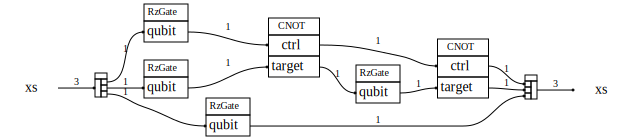

In [12]:
@attrs.frozen
class ElectricEnergyTerm(Bloq):
    eta: int  # Number of qubits in xs register
    t: float  # Timestep multiplier for Rz gate angles

    @property
    def signature(self) -> Signature:
        """Defines the signature for the ElectricEnergyTerm Bloq with an 'm'-qubit input."""
        return Signature.build(xs=self.eta)

    def build_composite_bloq(
        self, bb: BloqBuilder, *, xs: SoquetT
    ) -> Dict[str, SoquetT]:

        qubits = bb.split(xs)
    
        # Initial Rz gates with angles t * 2^i on each qubit corresponding to linear term in Eq.70 
        for i in range(self.eta):
            angle = self.t * (2 ** i)
            qubits[i] = bb.add(RzGate(angle), qubit=qubits[i])

        # Implementing the quadratic term in Eq.70 
        for j in range(self.eta - 2):
            for k in range(j + 1, self.eta - 1):
                angle = self.t * (2 ** (j + k - 1))
                
                # CNOT(j -> k)
                qubits[j], qubits[k] = bb.add(CNOT(), ctrl=qubits[j], target=qubits[k])

                # Rz(2 * angle) on target qubit k
                qubits[k] = bb.add(RzGate(2 * angle), qubit=qubits[k])

                # CNOT(j -> k) again to complete the operation
                qubits[j], qubits[k] = bb.add(CNOT(), ctrl=qubits[j], target=qubits[k])

        return {'xs': bb.join(qubits)}

# To visualize the bloq
show_bloq(ElectricEnergyTerm(eta=3, t = 1).decompose_bloq())

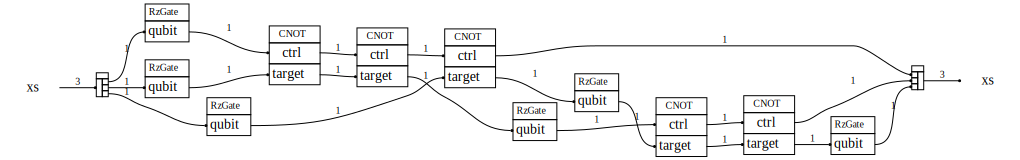

In [15]:
@attrs.frozen
class SimplifiedElectricEnergyTerm(Bloq):
    eta: int  # Number of qubits in xs register
    t: float  # Timestep multiplier for Rz gate angles

    @property
    def signature(self) -> Signature:
        """Defines the signature for the ElectricEnergyTerm Bloq with an 'm'-qubit input."""
        return Signature.build(xs=self.eta)

    def build_composite_bloq(
        self, bb: BloqBuilder, *, xs: SoquetT
    ) -> Dict[str, SoquetT]:

        qubits = bb.split(xs)
    
        # Initial Rz gates with angles t * 2^i on each qubit corresponding to linear term in Eq.70 
        for i in range(self.eta):
            for j in range(i, self.eta):
                if i == 0:
                    # Apply Rz with angle t * 2^j on qubit j
                    angle = self.t * (2 ** j)
                    qubits[j] = bb.add(RzGate(angle), qubit=qubits[j])
                else:
                    # Apply CNOT between qubits[i-1] and qubits[j]
                    qubits[i - 1], qubits[j] = bb.add(CNOT(), ctrl=qubits[i - 1], target=qubits[j])
                    
                    # Apply Rz with angle t * 2^(j + i - 1) on qubit j
                    angle = self.t * (2 ** (j + i - 1))
                    qubits[j] = bb.add(RzGate(angle), qubit=qubits[j])

            # Apply a final CNOT between qubits[i] and qubits[i + 1] if within bounds
            if i < self.eta - 1:
                qubits[i], qubits[i + 1] = bb.add(CNOT(), ctrl=qubits[i], target=qubits[i + 1])

        return {'xs': bb.join(qubits)}

show_bloq(SimplifiedElectricEnergyTerm(eta = 3, t = 1).decompose_bloq())

Check some of the circuits using the usual quantum circuit model.

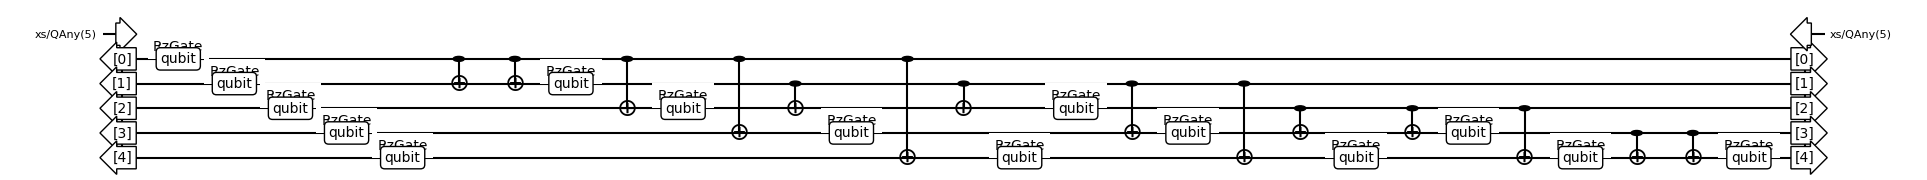

In [16]:
from qualtran.drawing import get_musical_score_data, draw_musical_score
cbloq = SimplifiedElectricEnergyTerm(eta=5, t = 1).decompose_bloq()
msd = get_musical_score_data(cbloq)
fig, ax = draw_musical_score(msd)
fig.set_figwidth(20)